In [24]:
'''
プログラム開始地点

ライブラリインポート
'''
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder # 文字列変数を数値化するエンコーダー
from sklearn.preprocessing import OneHotEncoder # 文字列変数をダミー変数にするエンコーダー
from sklearn.compose import ColumnTransformer # DFの1列だけをOne_Hot_Encoding形式に変換するため
from scipy.stats import norm
from scipy import stats

## グラフ用
import matplotlib.pyplot as plt
import seaborn as sns

## optuna関連
import optuna
import warnings

# optunaのログを抑える
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 機械学習
import lightgbm as lgb

# モデル保存
import pickle

## 分割用
# train_test_split (学習＋検証用、テストデータ)
from sklearn.model_selection import train_test_split

# KFold交差検証    (学習用、検証用)
from sklearn.model_selection import KFold

## エラー
from sklearn.metrics import mean_squared_error

In [ ]:
'''
再現性用
'''
np.random.seed(43)
    
    
    


count    195941.000000
mean         59.200137
std          38.569170
min           0.000000
25%          31.683000
50%          54.105000
75%          71.681000
max         487.471000
Name: pm25_mid, dtype: float64

Skewness: 1.728424256553706
Kurtosis: 5.0517066611721155


<AxesSubplot:xlabel='pm25_mid', ylabel='Density'>

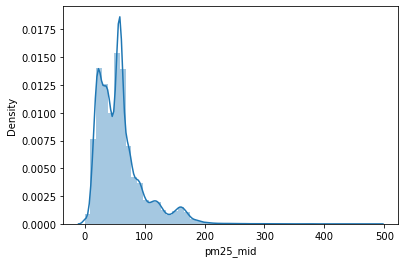

In [17]:
'''
データ読み込み
確認1
'''
## ディレクトリ、ファイル名個別 ##
data_dir = "C:\\Users\\akihi\\sony_pm25"
train_path = "train.csv"   # 学習用csvがある
test_path = "test.csv"     # テスト用csvが分かれている
result_path = "result.csv" # 結果出力用のcsvファイル

## 各種パスの作成 ##
input_path = os.path.join(data_dir,train_path) # 学習データパス
input_path_p = os.path.join(data_dir,test_path) # 推論用データパス
output_path = os.path.join(data_dir,result_path) # 出力ファイルパス (本番データ分析結果)

## ファイル読み込み ##
df = pd.read_csv(input_path)     # 学習データを読み込む
df_p = pd.read_csv(input_path_p) # 推論用データを読み込む

## ラベルデータの分布確認 ##
display(df["pm25_mid"].describe())                  # ラベルデータの概要を表示
print("Skewness: {}".format(df["pm25_mid"].skew())) # データの歪度
print("Kurtosis: {}".format(df["pm25_mid"].kurt())) # データの尖度
sns.distplot(df["pm25_mid"])                        # ラベルデータのヒストグラム(分布を確認)

In [ ]:
'''
データ確認2

説明変数が多すぎて処理が重くなりすぎるかもしれないので、要注意
'''

## 散布図行列 ##
sns.pairplot(df)

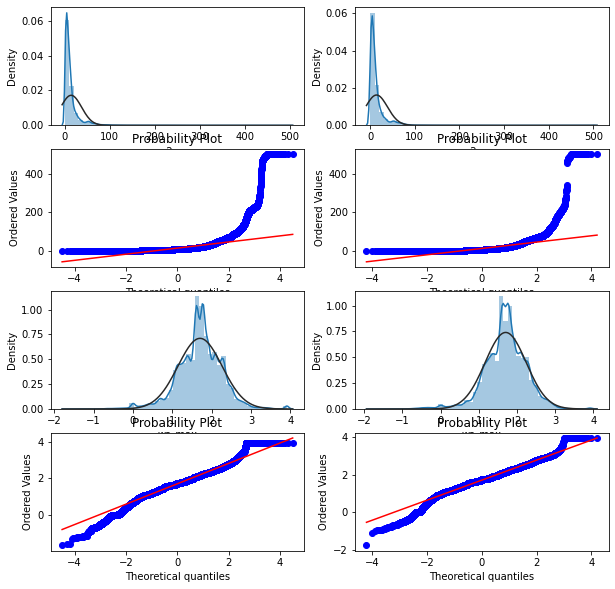

In [18]:
'''
データ前処理1

分布の歪みが見られる説明変数について、正規分布に近付くように対数を取る
学習データと推論用データの両方で対数変換
'''

#so2_max対数変換を実施, 0の値があるとエラーが出るため、0の場合は変換しないようにする。
#df['so2_max'] = df['so2_max'].where(df['so2_max']==0 , np.log(df['so2_max'])) # 条件に合わない場合(0でない場合)は対数変換
#df_p['so2_max'] = df_p['so2_max'].where(df_p['so2_max']==0 , np.log(df_p['so2_max'])) # 条件に合わない場合(0でない場合)は対数変換

#ws_max対数変換を実施, 0の値があるとエラーが出るため、0の場合は変換しないようにする。
df['ws_max'] = df['ws_max'].where(df['ws_max']==0 , np.log(df['ws_max'])) # 条件に合わない場合(0でない場合)は対数変換
df_p['ws_max'] = df_p['ws_max'].where(df_p['ws_max']==0 , np.log(df_p['ws_max'])) # 条件に合わない場合(0でない場合)は対数変換

## グラフを2x2の配置で表示
fig = plt.figure(figsize=(10,10))

# so_max用
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)

sns.distplot(df['so2_max'], fit=norm, ax=ax1);
sns.distplot(df_p['so2_max'], fit=norm, ax=ax2);
res = stats.probplot(df['so2_max'], plot=ax3)
res2 = stats.probplot(df_p['so2_max'], plot=ax4)

# ws_max用
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

sns.distplot(df['ws_max'], fit=norm, ax=ax5);
sns.distplot(df_p['ws_max'], fit=norm, ax=ax6); 
res3 = stats.probplot(df['ws_max'], plot=ax7)
res4 = stats.probplot(df_p['ws_max'], plot=ax8)


In [19]:
'''
データ前処理2

不要な説明変数の削除、新規説明変数の作成
'''

## *_varと*_cntを用いて標本平均の標本標準偏差 = 標本平均の母標準偏差推定値＝＞「平均値の推定ばらつき(e_mn_sd)」という指標に纏める
# co
df.insert(loc=10, column='co_e_mn_sd', value=(np.sqrt(df['co_var']) / (np.sqrt(df['co_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='co_mid_l', value=df['co_mid'] - df['co_e_mn_sd'])
df.insert(loc=10, column='co_mid_h', value=df['co_mid'] + df['co_e_mn_sd'])

df_p.insert(loc=10, column='co_e_mn_sd', value=(np.sqrt(df_p['co_var']) / (np.sqrt(df_p['co_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='co_mid_l', value=df_p['co_mid'] - df_p['co_e_mn_sd'])
df_p.insert(loc=10, column='co_mid_h', value=df_p['co_mid'] + df_p['co_e_mn_sd'])


# o3
df.insert(loc=10, column='o3_e_mn_sd', value=(np.sqrt(df['o3_var']) / (np.sqrt(df['o3_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='o3_mid_l', value=df['o3_mid'] - df['o3_e_mn_sd'])
df.insert(loc=10, column='o3_mid_h', value=df['o3_mid'] + df['o3_e_mn_sd'])

df_p.insert(loc=10, column='o3_e_mn_sd', value=(np.sqrt(df_p['o3_var']) / (np.sqrt(df_p['o3_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='o3_mid_l', value=df_p['o3_mid'] - df_p['o3_e_mn_sd'])
df_p.insert(loc=10, column='o3_mid_h', value=df_p['o3_mid'] + df_p['o3_e_mn_sd'])


# so2
df.insert(loc=10, column='so2_e_mn_sd', value=(np.sqrt(df['so2_var']) / (np.sqrt(df['so2_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='so2_mid_l', value=df['so2_mid'] - df['so2_e_mn_sd'])
df.insert(loc=10, column='so2_mid_h', value=df['so2_mid'] + df['so2_e_mn_sd'])

df_p.insert(loc=10, column='so2_e_mn_sd', value=(np.sqrt(df_p['so2_var']) / (np.sqrt(df_p['so2_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='so2_mid_l', value=df_p['so2_mid'] - df_p['so2_e_mn_sd'])
df_p.insert(loc=10, column='so2_mid_h', value=df_p['so2_mid'] + df_p['so2_e_mn_sd'])


# no2
df.insert(loc=10, column='no2_e_mn_sd', value=(np.sqrt(df['no2_var']) / (np.sqrt(df['no2_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='no2_mid_l', value=df['no2_mid'] - df['no2_e_mn_sd'])
df.insert(loc=10, column='no2_mid_h', value=df['no2_mid'] + df['no2_e_mn_sd'])

df_p.insert(loc=10, column='no2_e_mn_sd', value=(np.sqrt(df_p['no2_var']) / (np.sqrt(df_p['no2_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='no2_mid_l', value=df_p['no2_mid'] - df_p['no2_e_mn_sd'])
df_p.insert(loc=10, column='no2_mid_h', value=df_p['no2_mid'] + df_p['no2_e_mn_sd'])


# temperature
df.insert(loc=10, column='tp_e_mn_sd', value=(np.sqrt(df['temperature_var']) / (np.sqrt(df['temperature_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='tp_mid_l', value=df['temperature_mid'] - df['tp_e_mn_sd'])
df.insert(loc=10, column='tp_mid_h', value=df['temperature_mid'] + df['tp_e_mn_sd'])

df_p.insert(loc=10, column='tp_e_mn_sd', value=(np.sqrt(df_p['temperature_var']) / (np.sqrt(df_p['temperature_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='tp_mid_l', value=df_p['temperature_mid'] - df_p['tp_e_mn_sd'])
df_p.insert(loc=10, column='tp_mid_h', value=df_p['temperature_mid'] + df_p['tp_e_mn_sd'])


# humidity
df.insert(loc=10, column='hmd_e_mn_sd', value=(np.sqrt(df['humidity_var']) / (np.sqrt(df['humidity_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='hmd_mid_l', value=df['humidity_mid'] - df['hmd_e_mn_sd'])
df.insert(loc=10, column='hmd_mid_h', value=df['humidity_mid'] + df['hmd_e_mn_sd'])

df_p.insert(loc=10, column='hmd_e_mn_sd', value=(np.sqrt(df_p['humidity_var']) / (np.sqrt(df_p['humidity_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='hmd_mid_l', value=df_p['humidity_mid'] - df_p['hmd_e_mn_sd'])
df_p.insert(loc=10, column='hmd_mid_h', value=df_p['humidity_mid'] + df_p['hmd_e_mn_sd'])


# pressure
df.insert(loc=10, column='pr_e_mn_sd', value=(np.sqrt(df['pressure_var']) / (np.sqrt(df['pressure_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='pr_mid_l', value=df['pressure_mid'] - df['pr_e_mn_sd'])
df.insert(loc=10, column='pr_mid_h', value=df['pressure_mid'] + df['pr_e_mn_sd'])

df_p.insert(loc=10, column='pr_e_mn_sd', value=(np.sqrt(df_p['pressure_var']) / (np.sqrt(df_p['pressure_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='pr_mid_l', value=df_p['pressure_mid'] - df_p['pr_e_mn_sd'])
df_p.insert(loc=10, column='pr_mid_h', value=df_p['pressure_mid'] + df_p['pr_e_mn_sd'])


# ws
df.insert(loc=10, column='ws_e_mn_sd', value=(np.sqrt(df['ws_var']) / (np.sqrt(df['ws_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='ws_mid_l', value=df['ws_mid'] - df['ws_e_mn_sd'])
df.insert(loc=10, column='ws_mid_h', value=df['ws_mid'] + df['ws_e_mn_sd'])

df_p.insert(loc=10, column='ws_e_mn_sd', value=(np.sqrt(df_p['ws_var']) / (np.sqrt(df_p['ws_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='ws_mid_l', value=df_p['ws_mid'] - df_p['ws_e_mn_sd'])
df_p.insert(loc=10, column='ws_mid_h', value=df_p['ws_mid'] + df_p['ws_e_mn_sd'])


# dew
df.insert(loc=10, column='dew_e_mn_sd', value=(np.sqrt(df['dew_var']) / (np.sqrt(df['dew_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df.insert(loc=10, column='dew_mid_l', value=df['dew_mid'] - df['dew_e_mn_sd'])
df.insert(loc=10, column='dew_mid_h', value=df['dew_mid'] + df['dew_e_mn_sd'])

df_p.insert(loc=10, column='dew_e_mn_sd', value=(np.sqrt(df_p['dew_var']) / (np.sqrt(df_p['dew_cnt']))))
# ダメかも分からないが、平均値が無いので、中央値に対して平均値の推定ばらつきを適用して、lowとhighを求める
df_p.insert(loc=10, column='dew_mid_l', value=df_p['dew_mid'] - df_p['dew_e_mn_sd'])
df_p.insert(loc=10, column='dew_mid_h', value=df_p['dew_mid'] + df_p['dew_e_mn_sd'])


# 不要な変数を削除(年月日)
#df.drop('year',axis=1,inplace=True) # dateに纏めたので不要
df.drop('month',axis=1,inplace=True)
df.drop('day',axis=1,inplace=True)
#df_p.drop('year',axis=1,inplace=True)
df_p.drop('month',axis=1,inplace=True)
df_p.drop('day',axis=1,inplace=True)


# 不要な変数を削除(国名、市名)
df.drop('Country',axis=1,inplace=True) # 緯度経度で十分
#df.drop('City',axis=1,inplace=True) # 緯度経度で十分
df_p.drop('Country',axis=1,inplace=True) # 緯度経度で十分
#df_p.drop('City',axis=1,inplace=True) # 緯度経度で十分


'''
"City"をラベルエンコーディング
'''

# GroupKFold用のgroup作成関数
def get_groups(df_2):
    le = LabelEncoder() # 文字列を数値に変換するインスタンスを作成
    le.fit(df_2['City']) # 対象のリストを用いて、文字列➡数値のルールを作成する
    groups = le.transform(df_2['City']) # 実際に文字列➡数値を実行する
    
    return groups

# 学習データとテストデータを結合 (共通でラベルエンコーディングしたら後で分割)
len_df = len(df)
display(len_df)
df_2 = pd.concat([df,df_p],axis=0)
display(len(df_2))

## df['Country']を文字列からラベルエンコーディング
groups = get_groups(df_2=df_2)
city = pd.DataFrame(data=groups, columns=['City'])
#display("country_after:",country)

# 学習データとテストデータを分割
city_t = city[:len_df]
#display("country_t:",country_t)
city_p = city[len_df:]
city_p.reset_index(inplace=True, drop=True) # idが後半の物になっている。後でdf_p本体と結合する際にidが異なると上手く結合できないため、idを振り直す
#display("country_p:",country_p)

# 学習データのdf['Country']を置き換え
df.drop('City',axis=1,inplace=True) # 数値化した['Country']に置き換えるため削除する
df.insert(loc=4, column='City', value=city_t)

# テストデータのdf_p['Country']を置き換え
df_p.drop('City',axis=1,inplace=True) # 数値化した['Country']に置き換えるため削除する
df_p.insert(loc=4, column='City', value=city_p)

'''
推論用データのid列を分割
(id列は推論に不要なため分割して、推論後に再結合する)
'''

X_test_p = df_p.iloc[:,1::] # 本番用dfのid番号以外の列をX_test_pとする
test_p_id = df_p['id'] # 本番用dfのid番号列をtest_p_idとする。後で予測結果に結合する。
X_train_val_test = df.iloc[:,1:-1] # 学習用dfのid番号と目的変数以外の列をX_train_val_testとする。
y_train_val_test = df['pm25_mid'] # 学習用dfの目的変数の列をy_train_val_testとする。

display(X_train_val_test)
display(X_test_p)
display(y_train_val_test)
display(test_p_id)

195941

249450

,year,lat,lon,City,co_cnt,co_min,dew_mid_h,dew_mid_l,dew_e_mn_sd,ws_mid_h,...,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var
0,2019,-27.46794,153.02809,24,38,0.749,11.246621,9.469379,0.888621,1.305288,...,42,0.241,1.088,1.131725,1.983,17,7.671,10.358,15.112,13.424
1,2019,-12.46113,130.84185,54,47,2.594,23.993546,23.632454,0.180546,3.938721,...,48,0.828,3.473,2.000939,10.411,62,21.324,23.813,24.221,2.021
2,2019,-37.81400,144.96332,146,17,1.190,13.670460,12.595540,0.537460,2.461615,...,125,0.000,2.107,2.090505,15.719,22,10.309,13.133,15.422,6.355
3,2019,-32.92953,151.78010,176,63,4.586,10.969923,10.400077,0.284923,0.721606,...,52,0.284,0.503,1.278709,2.485,116,7.146,10.685,13.344,9.417
4,2019,-31.95224,115.86140,193,47,4.689,3.487197,3.066803,0.210197,0.892805,...,102,0.500,0.755,1.222598,1.937,93,1.091,3.277,12.272,4.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,2021,30.33218,-81.65565,103,12,0.694,23.729873,21.628127,1.050873,3.123247,...,22,2.195,2.710,1.812379,3.757,12,16.774,22.679,26.058,13.252
195937,2021,36.17497,-115.13722,133,14,0.528,15.509006,13.972994,0.768006,3.378727,...,51,1.002,2.974,1.925853,8.354,12,10.432,14.741,15.827,7.078
195938,2021,43.03890,-87.90647,150,171,1.975,3.981897,3.080103,0.450897,1.156971,...,125,0.994,1.087,0.947014,0.612,26,2.049,3.531,6.686,5.286
195939,2021,21.02450,105.84117,88,31,2.613,7.744695,7.141305,0.301695,3.209248,...,266,1.005,3.058,1.792592,6.085,51,1.922,7.443,7.716,4.642


,year,lat,lon,City,co_cnt,co_min,dew_mid_h,dew_mid_l,dew_e_mn_sd,ws_mid_h,...,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var
0,2019,-34.92866,138.59863,2,155,0.091,9.415765,6.944235,1.235765,2.881844,...,111,0.098,2.411,2.323661,24.608,26,3.057,8.180,15.841,39.705
1,2019,-33.86785,151.20732,243,23,1.037,15.941847,14.780153,0.580847,3.299795,...,158,0.101,2.982,2.111546,15.957,47,11.090,15.361,19.227,15.857
2,2019,50.85045,4.34878,25,28,0.096,4.848321,3.973679,0.437321,1.544238,...,64,0.218,1.200,1.758203,7.584,44,1.055,4.411,6.955,8.415
3,2019,43.84864,18.35644,225,122,0.479,0.539340,0.428660,0.055340,1.306514,...,149,0.504,1.172,1.350926,2.696,16,0.482,0.484,0.932,0.049
4,2019,-23.17944,-45.88694,246,158,6.198,11.586598,11.293402,0.146598,1.515417,...,164,0.409,1.412,1.141672,1.754,165,6.253,11.440,12.473,3.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53504,2021,36.98615,35.32531,0,97,4.674,3.325988,2.898012,0.213988,3.239151,...,93,0.201,2.878,2.001075,12.130,86,0.451,3.112,4.512,3.938
53505,2021,40.19559,29.06013,28,123,17.621,6.959573,6.686427,0.136573,1.604478,...,114,0.473,1.491,1.089908,1.468,115,3.894,6.823,6.861,2.145
53506,2021,41.00500,39.72694,266,150,0.128,9.820849,7.723151,1.048849,3.753832,...,179,1.001,3.605,1.617406,3.965,12,5.269,8.772,12.661,13.201
53507,2021,51.50853,-0.12574,138,21,0.057,11.114488,10.803512,0.155488,1.085325,...,41,0.077,0.803,1.356866,3.268,34,10.906,10.959,12.744,0.822


0          19.901
1          13.741
2          25.918
3         174.370
4         167.063
           ...   
195936     16.150
195937     16.895
195938     86.299
195939     36.523
195940     62.021
Name: pm25_mid, Length: 195941, dtype: float64

0        195942
1        195943
2        195944
3        195945
4        195946
          ...  
53504    249446
53505    249447
53506    249448
53507    249449
53508    249450
Name: id, Length: 53509, dtype: int64

In [20]:
'''
データ前処理3

学習データ＋検証データとテストデータに分割 (テストデータ:20%)
'''

X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_val_test, y_train_val_test, test_size=0.20)

# 分割後にインデックスを振りなおす
X_train_val=X_train_val.reset_index(drop=True)
y_train_val=y_train_val.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

print("X_train_val_test.shape:{}".format(X_train_val_test.shape))
print("y_train_val_test.shape:{}".format(y_train_val_test.shape))        
print("X_train_val.shape:{}".format(X_train_val.shape))
print("y_train_val.shape:{}".format(y_train_val.shape))        
print("X_test.shape:{}".format(X_test.shape))
print("y_test.shape:{}".format(y_test.shape))        


X_train_val_test.shape:(195941, 76)
y_train_val_test.shape:(195941,)
X_train_val.shape:(156752, 76)
y_train_val.shape:(156752,)
X_test.shape:(39189, 76)
y_test.shape:(39189,)


In [38]:
'''
学習、ベストパラメータ探索、推論
'''

## 最終予測用lgbm関数
def light_gbm(best_param,train_lgb,X_val_a,y_val_a,X_test_p,test_p_id,output_path):
    params = {
        "verbose":-1,
        "objective":"regression",
        "metric":"rmse",
        "random_state":43, # ランダムシード設定
        "max_depth":8,
        # ベストパラメータから値を取得・使用
        "num_leaves":best_param["num_leaves"],
        "bagging_fraction":best_param["bagging_fraction"],
        "bagging_freq":best_param["bagging_freq"]
    }
    
    # 最終LightGBMモデル
    best_lgbm = lgb.train(params,train_lgb,
                          num_boost_round=1000,
                          valid_sets=[train_lgb, validation_lgb],
                          categorical_feature=["City"], # int型の"City"をカテゴリ変数として指定する
                          verbose_eval=False,
                          early_stopping_rounds=100
                         )

    ## テストデータ(答えあり)を使って予測、rmse計算
    # 予測
    pred = best_lgbm.predict(X_val_a)
    # rmse計算
    rmse = np.sqrt(mean_squared_error(y_val_a, pred))
    
    ## テストデータ(本番)を使って予測、CSV保存
    # 予測
    y_pred_p = best_lgbm.predict(X_test_p)

    # 予測値をnumpy arrayからデータフレームに変換
    y_pred_p = pd.DataFrame(y_pred_p) 
    display("y_pred_p:\n",y_pred_p)

    # 目的変数pm25_midはログを取っているので、指数変換して元に戻す
    #    y_pred_p = np.exp(y_pred_p)
    # id列と出力したy_pred_pを結合する
    ans_col = pd.concat([test_p_id , y_pred_p],axis=1)
    ans_col.to_csv(output_path, header=False, index=False) # csvファイルを保存
    
    # 参考用にテストデータ(答えあり)のrmse値を返す
    return rmse

## ベストパラメータ探索用optuna関数
def objective(trial):
    # paramsでverbose:-1にセットし、更に、verbose_eval=Falseとすることで、
    # これ以上分岐できないというwarningメッセージが表示されない。
    # 当該メッセージ：[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
    # 参考URL：https://github.com/Microsoft/LightGBM/issues/1157
    # 木を表示させると分かりやすいかもしれない？
    # 参考：https://rightcode.co.jp/blog/information-technology/lightgbm-useful-for-kaggler#LightGBM

    params = {
        "verbose":-1,
        # 回帰
        "objective":"regression",
        "metric":"rmse",
        "random_state":43, # ランダムシード設定
        # パラメータの候補を整数の範囲で与える。
        # num_leavesは2~50の範囲で探索する。
        "num_leaves":trial.suggest_int("num_leaves", 5, 30),
        # パラメータの候補を小数の範囲で与える。
        "bagging_fraction":trial.suggest_uniform("bagging_fraction", 0.1,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",3,5),
        "max_depth":8
    }

    model = lgb.train(params, train_lgb, num_boost_round=1000,valid_sets=[train_lgb, validation_lgb],
                      categorical_feature=["City"], # int型の"City"をカテゴリ変数として指定する
                      verbose_eval=False,
                      early_stopping_rounds=100)
        
    # 検証データでモデルの評価(スコア確認)
    pred_lgbm = model.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val, pred_lgbm))
    
    return loss

best_params = []
best_values = []

## クロスバリデ―ション 
## optunaによる最適パラメータ探索実施、ブロック数個のベストパラメータが出力
## その後、ベストスコアのパラメータを用いてlgbmで予測

# クロスバリデーション
cv = GroupKFold(n_splits=5)

# クロスバリデーションでn_splits数にデータ(X_train_val_test, y_train_val_test)を分けた学習データと検証データのインデックスを得る。
# 今回の場合、trn_index : val_index = 4 : 1
for trn_index, val_index in cv.split(X_train_val_test,y_train_val_test,groups=groups[:len(X_train_val_test)]):
    
    # X_train_val_test => X_train_a, X_val_aに分割 
    X_train_a, X_val_a = X_train_val_test.loc[trn_index], X_train_val_test.loc[val_index]
    # y_train_val_test => y_train_a, y_val_aに分割 
    y_train_a, y_val_a = y_train_val_test[trn_index], y_train_val_test[val_index]
    
    # X_train_a、y_train_aをtrainとvalに分割 (train=0.8,val=0.2,学習データと検証データを分割している)
    X_train, X_val, y_train, y_val = train_test_split(X_train_a, y_train_a, test_size=0.2, random_state=43)
    # 学習データをlightgbm用に変換
    train_lgb = lgb.Dataset(X_train, y_train, categorical_feature=["City"]) # "City"をカテゴリ変数に変換
    # 検証データをlightgbm用に変換
    validation_lgb = lgb.Dataset(X_val, y_val, categorical_feature=["City"]) # "City"をカテゴリ変数に変換
    
    # ベイズ最適化
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=43))
    # 最適化を実施(回数、時間指定可能)
    # 30回実行し、最適値を推定
    study.optimize(objective,n_trials=30)
        
    # 最適なパラメータとその時の目的関数の返り値(np.mean(acc_results))つまり平均正解率
    print("best_value:", study.best_value)
    print("best_params:", study.best_params)
    
    best_params.append(study.best_params)
    best_values.append(study.best_value)

## テストデータを最終のベストモデルで予測、予測結果をcsvファイルに保管
# ベストrmse値のインデックスを取得
best_index = best_values.index(min(best_values))

#　ベストパラメータ(ベストrmse値)を取得
best_param = best_params[best_index]

## ベストパラメータを引数にして、lgbmを実施、テストデータ(答えあり)のrmseを受け取る
test_rmse = light_gbm(best_param,train_lgb,X_val_a,y_val_a,X_test_p,test_p_id,output_path)

print(f"test_rmse:{test_rmse}")

best_value: 19.82757885333892
best_params: {'num_leaves': 30, 'bagging_fraction': 0.8338212457659048, 'bagging_freq': 3}
best_value: 19.91178768910952
best_params: {'num_leaves': 27, 'bagging_fraction': 0.7218052048117369, 'bagging_freq': 4}
best_value: 19.81826771921634
best_params: {'num_leaves': 27, 'bagging_fraction': 0.7873410578753364, 'bagging_freq': 4}
best_value: 19.667758209733556
best_params: {'num_leaves': 25, 'bagging_fraction': 0.7573478019956666, 'bagging_freq': 4}
best_value: 19.532829031484546
best_params: {'num_leaves': 29, 'bagging_fraction': 0.8232369559057879, 'bagging_freq': 4}


'y_pred_p:\n'

,0
0,21.153511
1,40.061998
2,26.467612
3,53.210228
4,127.874891
...,...
53504,63.667736
53505,119.082687
53506,71.809198
53507,36.000149


test_rmse:26.687735811167034


In [ ]:
'''
学習、ベストパラメータ探索、推論(lightGBMTuner使用)

※内容はoptunaだが、乱数固定がより明確
'''

from optuna.integration import lightgbm as lgb_opt


## ベストパラメータ探索用optuna関数
def lgbm_optuna(params,train_lgb,validation_lgb):

    params = {
        "verbosity":-1,
        # 回帰
        "objective":"regression",
        "metric":"rmse",
        "deterministic":True, # 再現性確保
        "force_row_wise":True # 再現性確保
    }

    model = lgb.LightGBMTuner(
        params=params, 
        train_lgb, 
        valid_sets=validation_lgb,
        categorical_feature=["City"], # int型の"City"をカテゴリ変数として指定する
        optuna_seed = 43 # 再現性確保
    )
    
    model.run()
    model.best_params
    best_model = model.get_best_booster()
    
    # 以下作成中
    
    # 検証データでモデルの評価(スコア確認)
    
    pred_lgbm = model.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val, pred_lgbm))
    
    return loss

best_params = []
best_values = []

## クロスバリデ―ション 
## optunaによる最適パラメータ探索実施、ブロック数個のベストパラメータが出力
## その後、ベストスコアのパラメータを用いてlgbmで予測

# クロスバリデーション
cv = GroupKFold(n_splits=5)

# クロスバリデーションでn_splits数にデータ(X_train_val_test, y_train_val_test)を分けた学習データと検証データのインデックスを得る。
# 今回の場合、trn_index : val_index = 4 : 1
for trn_index, val_index in cv.split(X_train_val_test, y_train_val_test, groups=groups[:len(X_train_val_test)]):
    
    # X_train_val_test => X_train_a, X_val_aに分割 
    X_train_a, X_val_a = X_train_val_test.loc[trn_index], X_train_val_test.loc[val_index]
    # y_train_val_test => y_train_a, y_val_aに分割 
    y_train_a, y_val_a = y_train_val_test[trn_index], y_train_val_test[val_index]
    
    # X_train_a、y_train_aをtrainとvalに分割 (train=0.8,val=0.2,学習データと検証データを分割している)
    X_train, X_val, y_train, y_val = train_test_split(X_train_a, y_train_a, test_size=0.2, random_state=43)
    # 学習データをlightgbm用に変換
    train_lgb = lgb.Dataset(X_train, y_train, categorical_feature=["City"]) # "City"をカテゴリ変数に変換
    # 検証データをlightgbm用に変換
    validation_lgb = lgb.Dataset(X_val, y_val, categorical_feature=["City"]) # "City"をカテゴリ変数に変換

    # ベイズ最適化
    lgbm_optuna(params,train_lgb,validation_lgb)
    # ベイズ最適化
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=43))
    # 最適化を実施(回数、時間指定可能)
    # 30回実行し、最適値を推定
    study.optimize(objective,n_trials=30)

    # 最適なパラメータとその時の目的関数の返り値(np.mean(acc_results))つまり平均正解率
    print("best_value:", study.best_value)
    print("best_params:", study.best_params)

    best_params.append(study.best_params)
    best_values.append(study.best_value)

## テストデータを最終のベストモデルで予測、予測結果をcsvファイルに保管
# ベストrmse値のインデックスを取得
best_index = best_values.index(min(best_values))

#　ベストパラメータ(ベストrmse値)を取得
best_param = best_params[best_index]

## ベストパラメータを引数にして、lgbmを実施、テストデータ(答えあり)のrmseを受け取る
test_rmse = light_gbm(best_param,train_lgb,X_val_a,y_val_a,X_test_p,test_p_id,output_path)

## テストデータ(答えあり)を使って予測、rmse計算
# 予測
pred = best_lgbm.predict(X_val_a)
# rmse計算
rmse = np.sqrt(mean_squared_error(y_val_a, pred))
    
## テストデータ(本番)を使って予測、CSV保存
# 予測
y_pred_p = best_lgbm.predict(X_test_p)

# 予測値をnumpy arrayからデータフレームに変換
y_pred_p = pd.DataFrame(y_pred_p) 
display("y_pred_p:\n",y_pred_p)

# 目的変数pm25_midはログを取っているので、指数変換して元に戻す
#    y_pred_p = np.exp(y_pred_p)
# id列と出力したy_pred_pを結合する
ans_col = pd.concat([test_p_id , y_pred_p],axis=1)
ans_col.to_csv(output_path, header=False, index=False) # csvファイルを保存


print(f"test_rmse:{test_rmse}")
